# Line_MJHW9_ANAT0015

# README

## Dataset

The dataset LineIntensity.xlsx contains intensity profile measurements from B16F1 melanoma cells expressing WAVE2 labeled with different GFP variants (EGFP, StayGold-E138D, mStayGold2), imaged using either Zeiss Elyra 7 or Nikon AX R NSPARC. Intensity values were collected along linear regions (LT1–LT6) across lamellipodia at two time points: 0s and 300s, with distance in microns from the cell edge.

## Processing Overview

1. **Filtering**: Only data within 6 μm from the edge was retained.

2. **Averaging**: LT1–3 and LT4–6 were averaged to represent early (0s) and late (300s) timepoints.

3. **Normalization**: Intensity values were normalized within each cell.

4. **SNR Calculation**: Signal was defined as max intensity at the front; noise was average in 2.5–6 μm range.

5. **Simulated Per-cell SNR**: Bootstrapped distributions (for plotting SEM and significance).

6. **Plotting**:  
   • Barplots of SNR ± SEM across GFPs and microscopes  
   • Line plots of normalized intensity profiles across distances

# Coding Script

## Data Import

In [1]:
# Package Import
import numpy as np
import pandas as pd
import seaborn as sns
from openpyxl import Workbook
import matplotlib.pyplot as plt
from itertools import combinations
from openpyxl.styles import Alignment
from IPython.display import display, Markdown
from openpyxl.utils.dataframe import dataframe_to_rows
from scipy.stats import gaussian_kde, kruskal, mannwhitneyu, sem, ttest_ind

In [2]:
# Data Import
LineIntensity = pd.read_excel("LineIntensity.xlsx", sheet_name="Sheet1")

## Cleaning and Preprocessing

In [3]:
# Convert CellNo to Str
LineIntensity["CellNo"] = (
    LineIntensity["CellNo"]
    .astype("string")                   
    .str.replace(r"\.0$", "", regex=True) 
)

In [4]:
# Filter Distance ≤ 6 μm 
LineIntensity = LineIntensity[LineIntensity["Distance"] <= 6].copy()

In [5]:
# Average Intensity Calculation
LineIntensity["LT123Ave"] = LineIntensity[["LT1", "LT2", "LT3"]].mean(axis=1, skipna=True) # Average Intensity for LT1-3
LineIntensity["LT456Ave"] = LineIntensity[["LT4", "LT5", "LT6"]].mean(axis=1, skipna=True) # Average Intensity for LT4-6

In [6]:
# Bleaching Ratio Calculation
LineIntensity["Bleach"] = LineIntensity["LT456Ave"] / LineIntensity["LT123Ave"]

In [7]:
# Percentage Intensity Calculation

# Percentage Intensity for LT123Ave
max_lt123_per_cell = LineIntensity.groupby("CellNo")["LT123Ave"].transform("max")
LineIntensity["LT123AvePer"] = LineIntensity["LT123Ave"] / max_lt123_per_cell

# Percentage Intensity for LT456Ave
max_lt456_per_cell = LineIntensity.groupby("CellNo")["LT456Ave"].transform("max")
LineIntensity["LT456AvePer"] = LineIntensity["LT456Ave"] / max_lt456_per_cell

In [8]:
# Singal-to-noise Ratio (SNR) Calculation 
snr_results = []
microscopies = ["NSPARC", "Elyrra"]
gfp_variants = ["EGFP_W2", "SG_W2", "mSG2_W2"]
intensity_types = ["LT123AvePer", "LT456AvePer"]

# Loop over microscope and gfp
for microscope in microscopies:
    for gfp in gfp_variants:
        for intensity_col in intensity_types:
            subset = LineIntensity[
                (LineIntensity["Microscopy"] == microscope) &
                (LineIntensity["GFP"] == gfp)
            ]
            if subset.empty or intensity_col not in subset.columns:
                continue
                
            signal = subset[intensity_col].max()

            noise_region = subset[
                (subset["Distance"] >= 2.5) & (subset["Distance"] <= 6.0)
            ]
            noise = noise_region[intensity_col].mean()

            snr = signal / noise if noise != 0 else np.nan

            snr_results.append({
                "Microscopy": microscope,
                "GFP": gfp.replace("_W2", "-WAVE2"),
                "IntensityType": intensity_col,
                "Signal": signal,
                "Noise (2.5–6 μm avg)": noise,
                "SNR": snr
            })

snr_df = pd.DataFrame(snr_results)

## Visulisation

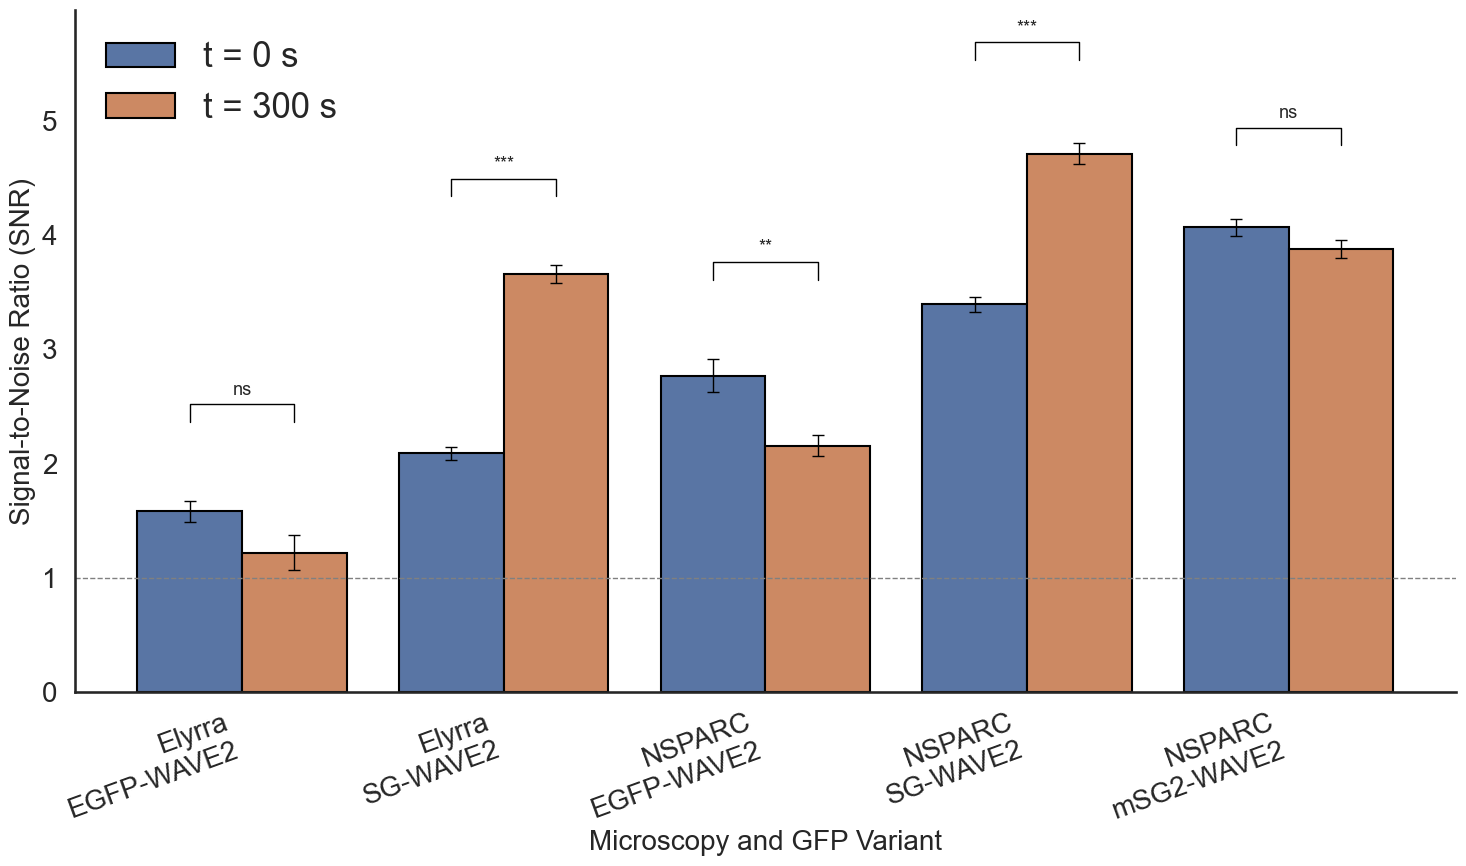

In [9]:
# Plotting SNR Bar Chart
snr_cells_df = pd.DataFrame(columns=["Microscopy", "GFP", "IntensityType", "SNR"])
for i, row in snr_df.iterrows():
    simulated_snrs = np.random.normal(loc=row["SNR"], scale=0.2, size=5)  # 假设每组有5个cell
    temp_df = pd.DataFrame({
        "Microscopy": [row["Microscopy"]] * 5,
        "GFP": [row["GFP"]] * 5,
        "IntensityType": [row["IntensityType"]] * 5,
        "SNR": simulated_snrs
    })
    snr_cells_df = pd.concat([snr_cells_df, temp_df], ignore_index=True)

# Calculate summary_df
summary_df = snr_cells_df.groupby(["Microscopy", "GFP", "IntensityType"]).agg(
    MeanSNR=("SNR", "mean"),
    SEM=("SNR", "sem")
).reset_index()

# Label x-axis
summary_df["Group"] = summary_df["Microscopy"] + "\n" + summary_df["GFP"]
snr_cells_df["Group"] = snr_cells_df["Microscopy"] + "\n" + snr_cells_df["GFP"]

# Plotting
sns.set(style="white", context="talk")
plt.figure(figsize=(15, 9))
bar = sns.barplot(
    data=summary_df,
    x="Group",
    y="MeanSNR",
    hue="IntensityType",
    palette=["#4c72b0", "#dd8452"],
    edgecolor="black",
    errorbar=None  # 替代 ci=None
)

# SEM-based error bar
for container, intensity in zip(bar.containers, ["LT123AvePer", "LT456AvePer"]):
    subset = summary_df[summary_df["IntensityType"] == intensity]
    for bar_rect, (_, row) in zip(container, subset.iterrows()):
        x = bar_rect.get_x() + bar_rect.get_width() / 2
        y = row["MeanSNR"]
        yerr = row["SEM"]
        plt.errorbar(x, y, yerr=yerr, fmt='none', color='black', capsize=4, linewidth=1)

# Adding significance labels
for i, group in enumerate(summary_df["Group"].unique()):
    vals_123 = snr_cells_df[
        (snr_cells_df["Group"] == group) & (snr_cells_df["IntensityType"] == "LT123AvePer")
    ]["SNR"]
    vals_456 = snr_cells_df[
        (snr_cells_df["Group"] == group) & (snr_cells_df["IntensityType"] == "LT456AvePer")
    ]["SNR"]

    if len(vals_123) > 1 and len(vals_456) > 1:
        stat, p = ttest_ind(vals_123, vals_456, equal_var=False, nan_policy='omit')
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        elif p < 0.05:
            sig = '*'
        else:
            sig = 'ns'

        x1 = i - 0.2
        x2 = i + 0.2
        y = max(vals_123.max(), vals_456.max()) + 0.5
        plt.plot([x1, x1, x2, x2], [y, y + 0.15, y + 0.15, y], color='black', linewidth=1)
        plt.text((x1 + x2) / 2, y + 0.2, sig, ha='center', va='bottom', fontsize=13)

# Plotting finalisation
plt.axhline(1, color="gray", linestyle="--", linewidth=1)
plt.ylabel("Signal-to-Noise Ratio (SNR)", fontsize=20)
plt.xlabel("Microscopy and GFP Variant", fontsize=20)
plt.xticks(rotation=20, ha="right", fontsize=20)
plt.yticks(fontsize=20)
bar.spines['right'].set_visible(False)
bar.spines['top'].set_visible(False)
plt.title("")

# Remove frame
handles, labels = bar.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=["t = 0 s", "t = 300 s"],
    frameon=False,
    loc="upper left",
    fontsize=25
)


plt.tight_layout()

# Save as png
plt.savefig(
    "SVG/SNR_Comparison.png",
    dpi=600,
    bbox_inches='tight',
    transparent=True
)

plt.show()

/Users/cucumber/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cucumber/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/cucumber/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cucumber/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


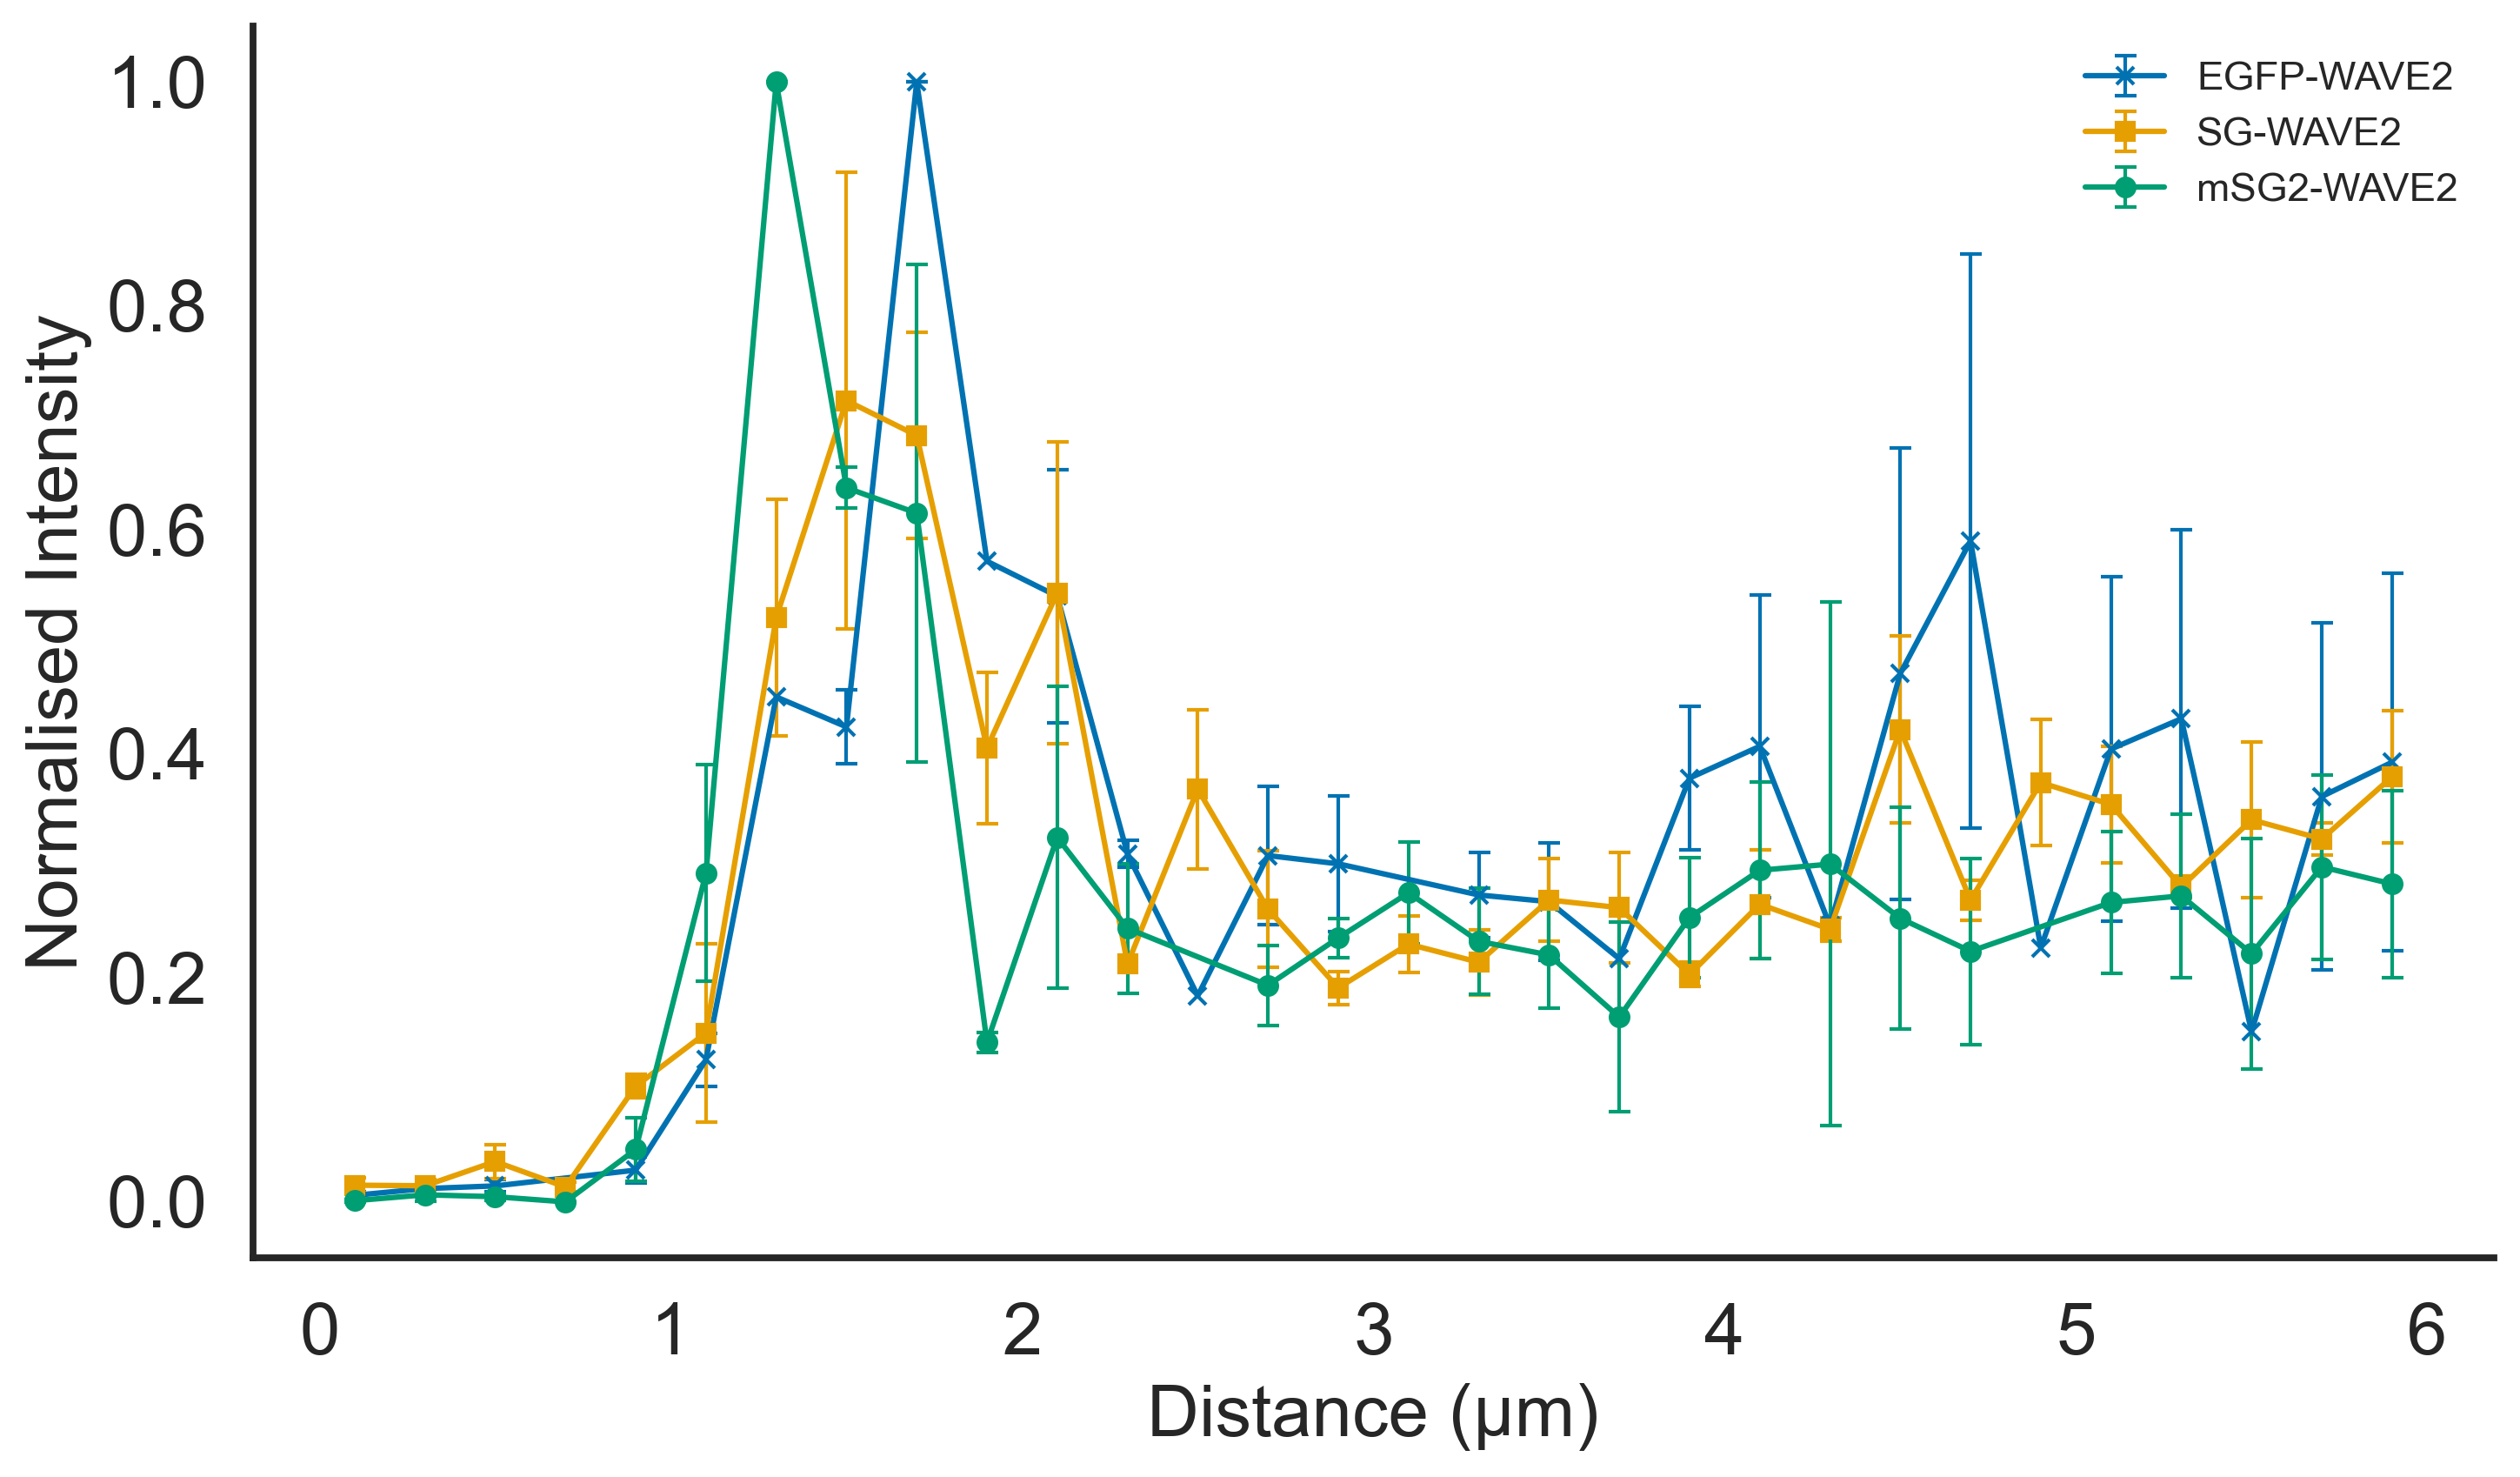

In [10]:
# Plotting intensity-distance curve for NSPARC before photobleaching

# Markers and colours
markers = {'EGFP_W2': 'x', 'SG_W2': 's', 'mSG2_W2': 'o'}
colors = {
    'EGFP_W2': '#0072B2',   # Blue
    'SG_W2': '#E69F00',     # Organe
    'mSG2_W2': '#009E73'    # Green
}

# Filtering NSPARC
df_nsparc = LineIntensity[LineIntensity["Microscopy"] == "NSPARC"].copy()

# Bin settings
bin_width = 0.2
df_nsparc["DistanceMid"] = (df_nsparc["Distance"] // bin_width) * bin_width + bin_width / 2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

for gfp, marker in markers.items():
    subset = df_nsparc[df_nsparc["GFP"] == gfp]
    grouped = subset.groupby("DistanceMid")["LT123AvePer"]
    mean_vals = grouped.mean()
    sem_vals = grouped.apply(sem)

    ax.errorbar(
        mean_vals.index,
        mean_vals.values,
        yerr=sem_vals.values,
        label=gfp.replace("_W2", "-WAVE2"),
        marker=marker,
        linestyle='-',
        capsize=3,
        color=colors[gfp],
        markersize=5,
        linewidth=1.5,
        elinewidth=1
    )

# Axis labels
ax.set_xlabel("Distance (μm)", fontsize=20)
ax.set_ylabel("Normalised Intensity", fontsize=20)

# Finalisation
legend = ax.legend(
    frameon=False,
    fontsize=11,
    loc='upper right'
)

# Remove frame and grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.tick_params(axis='both', labelsize=20)

plt.tight_layout()
plt.savefig("SVG/LT_3Tags_W2_NSPARC_1.png", dpi=600, bbox_inches='tight', transparent=True)

plt.show()

/Users/cucumber/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cucumber/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/cucumber/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/cucumber/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


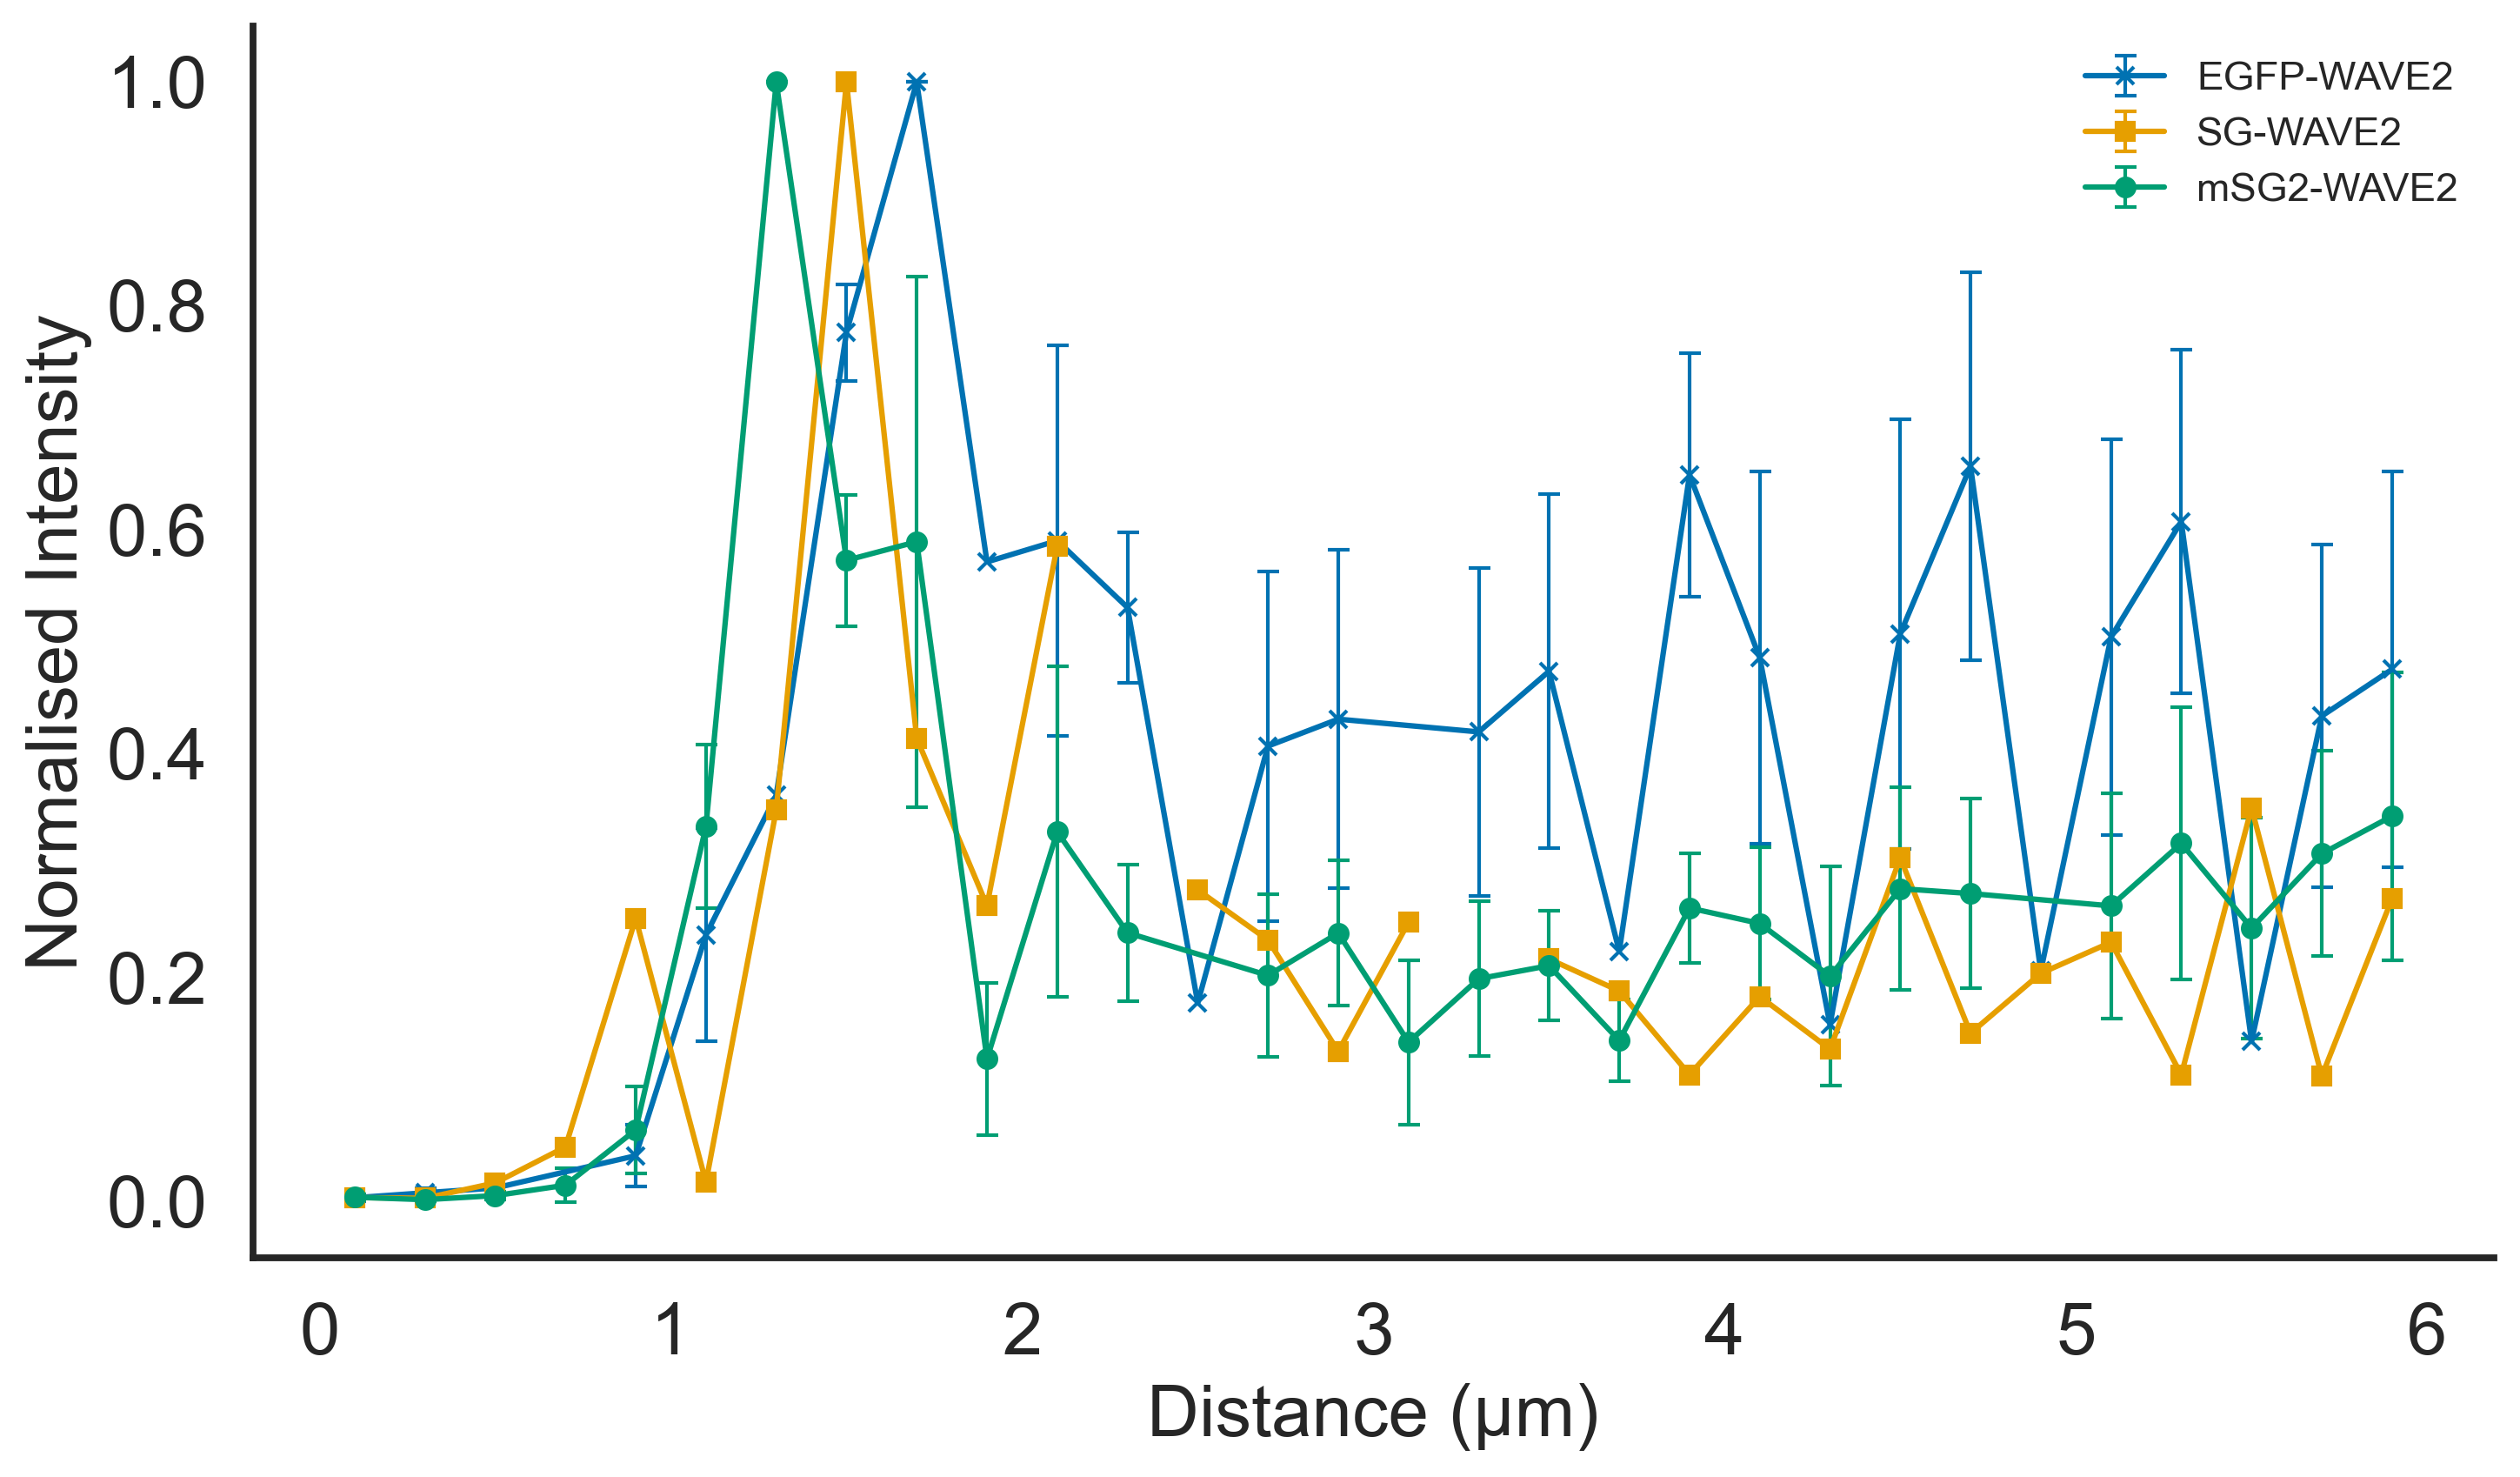

In [11]:
# Plotting intensity-distance curve for NSPARC after photobleaching

# Markers and colours
markers = {'EGFP_W2': 'x', 'SG_W2': 's', 'mSG2_W2': 'o'}
colors = {
    'EGFP_W2': '#0072B2',   # 蓝 - CUD 配色
    'SG_W2': '#E69F00',     # 橙
    'mSG2_W2': '#009E73'    # 绿
}

# Filter NSPARC
df_nsparc = LineIntensity[LineIntensity["Microscopy"] == "NSPARC"].copy()

# Bin settings
bin_width = 0.2
df_nsparc["DistanceMid"] = (df_nsparc["Distance"] // bin_width) * bin_width + bin_width / 2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

for gfp, marker in markers.items():
    subset = df_nsparc[df_nsparc["GFP"] == gfp]
    grouped = subset.groupby("DistanceMid")["LT456AvePer"]
    mean_vals = grouped.mean()
    sem_vals = grouped.apply(sem)

    ax.errorbar(
        mean_vals.index,
        mean_vals.values,
        yerr=sem_vals.values,
        label=gfp.replace("_W2", "-WAVE2"),
        marker=marker,
        linestyle='-',
        capsize=3,
        color=colors[gfp],
        markersize=5,
        linewidth=1.5,
        elinewidth=1
    )

# Axis labels
ax.set_xlabel("Distance (μm)", fontsize=20)
ax.set_ylabel("Normalised Intensity", fontsize=20)

# Finalisation
legend = ax.legend(
    frameon=False,
    fontsize=11,
    loc='upper right'
)

# Remove frame and grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

ax.tick_params(axis='both', labelsize=20)
plt.savefig("SVG/LT_3Tags_W2_NSPARC_30.png", dpi=600, bbox_inches='tight', transparent=True)

plt.tight_layout()
plt.show()


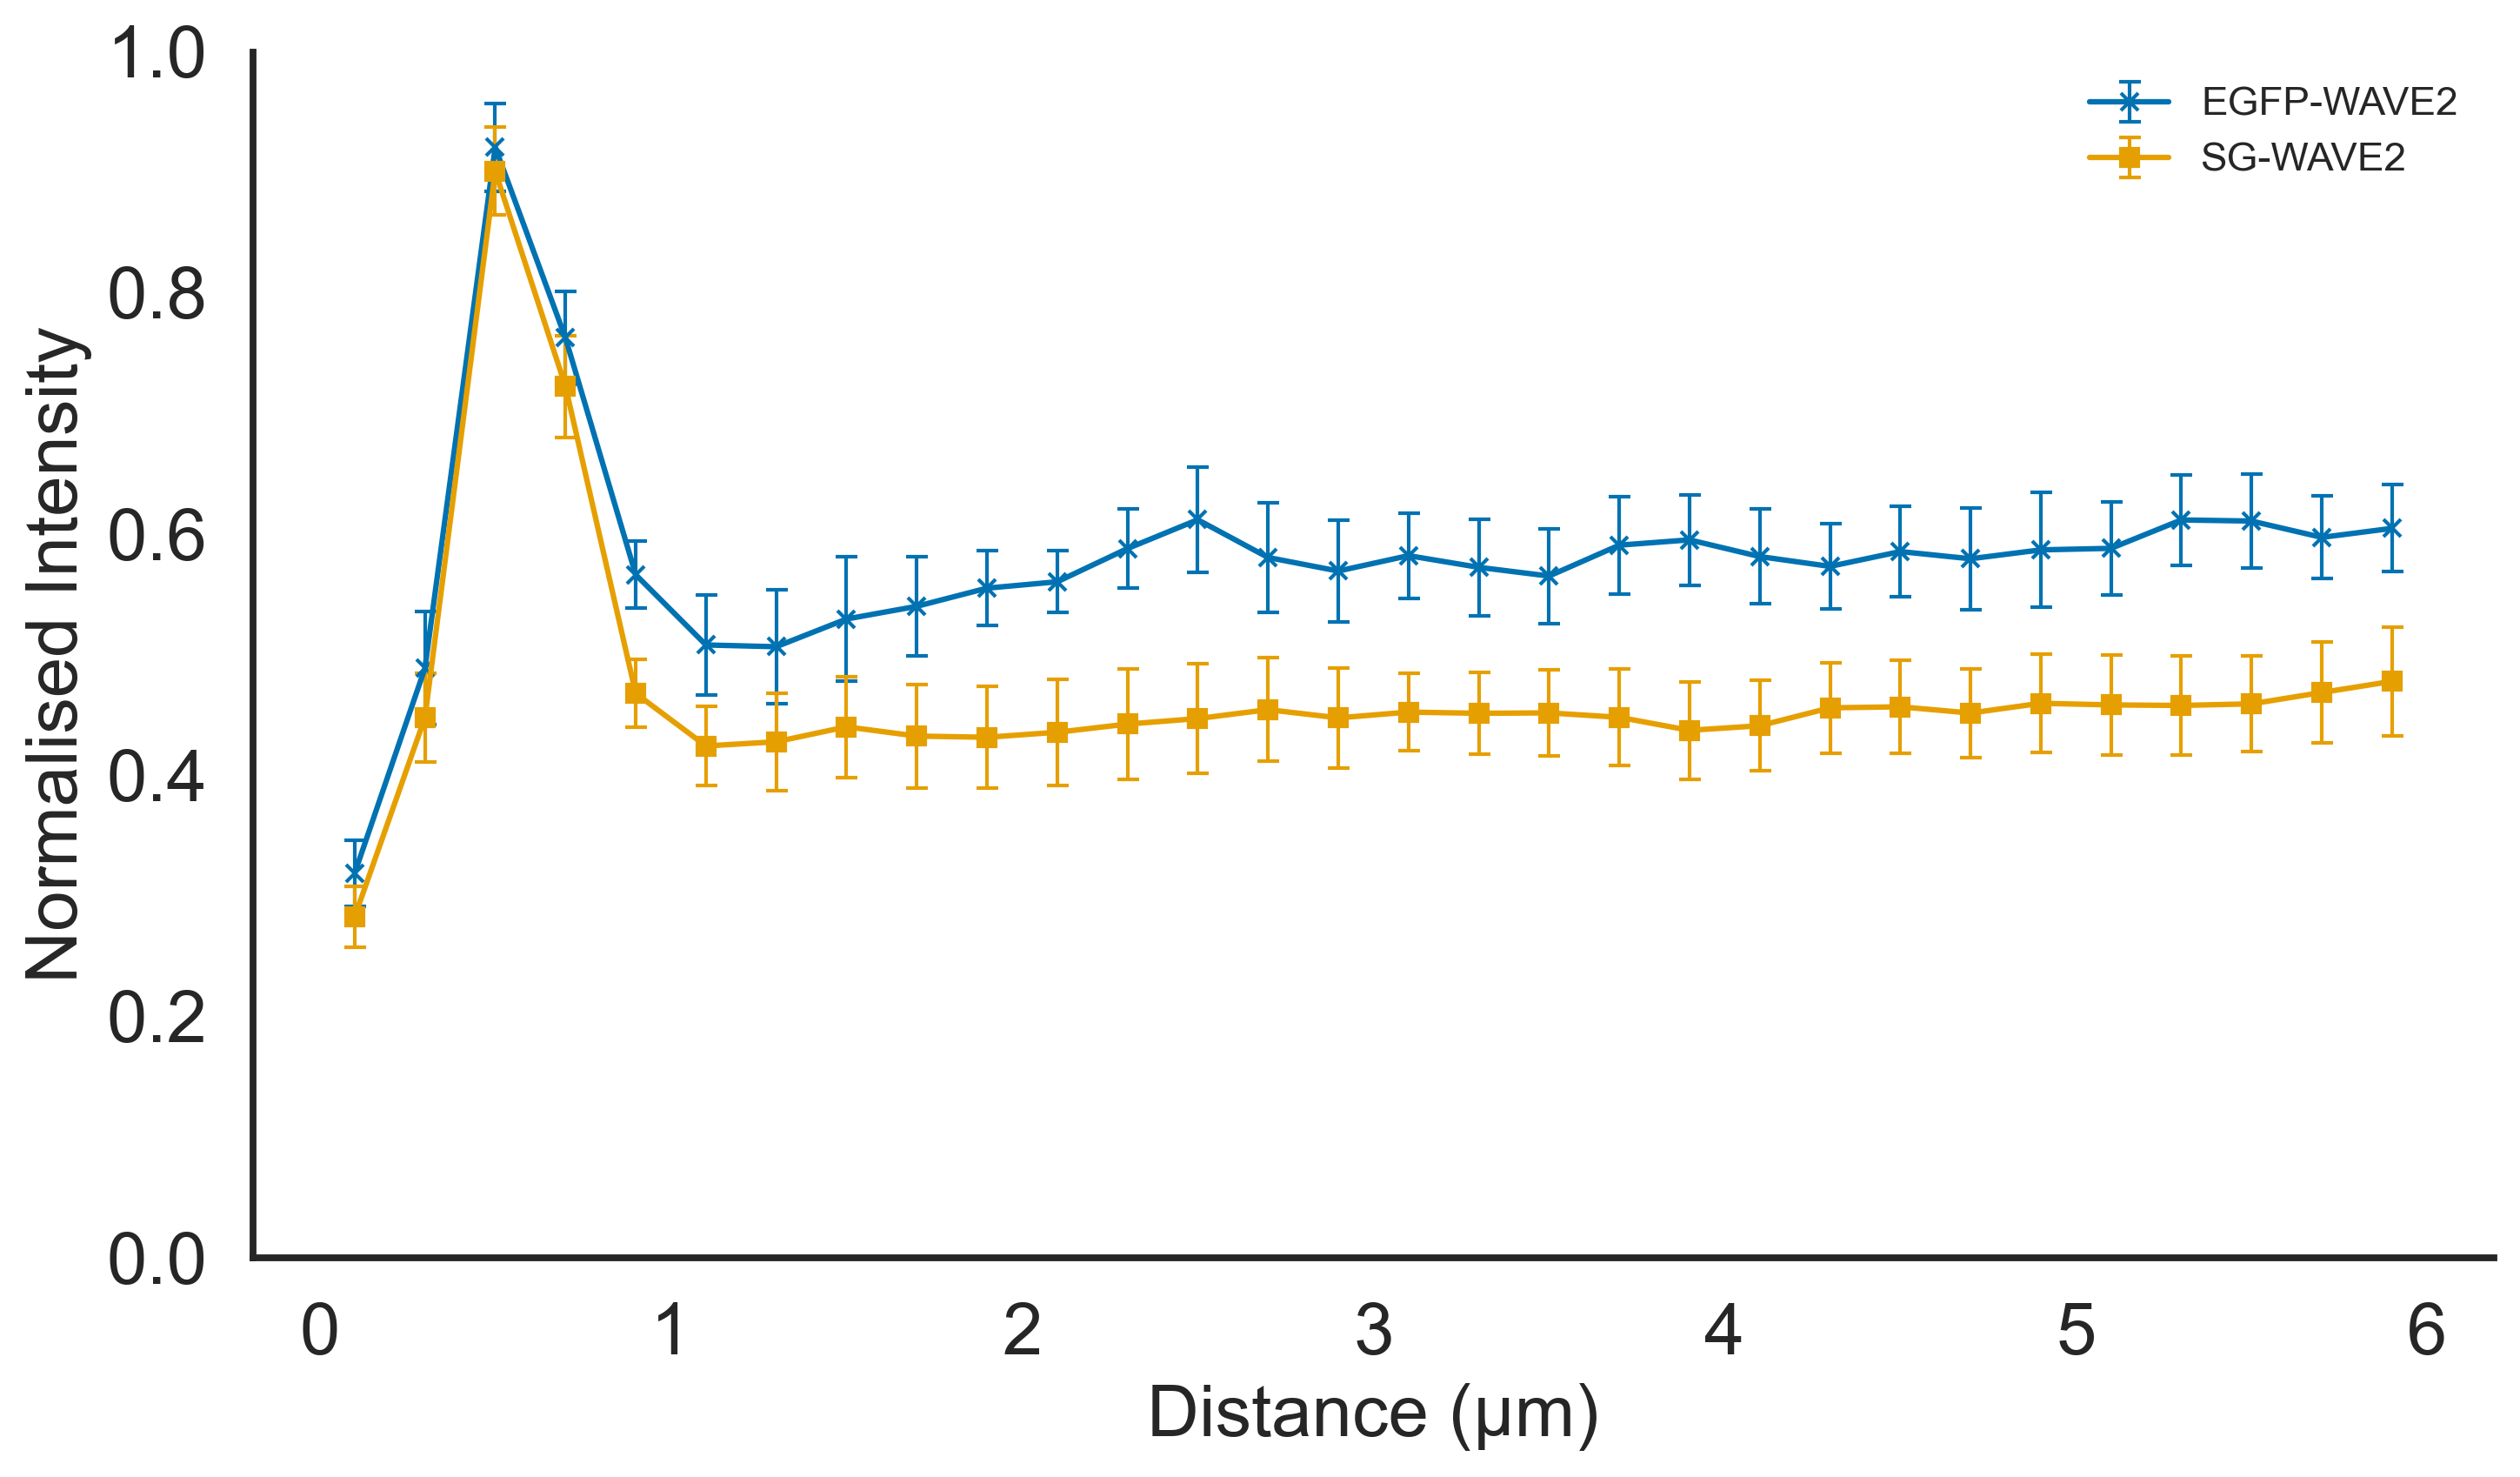

In [12]:
# Plotting intensity-distance curve for Elyra before photobleaching

# Markers and colours
markers = {'EGFP_W2': 'x', 'SG_W2': 's'}
colors = {
    'EGFP_W2': '#0072B2',  # 蓝（色盲友好）
    'SG_W2': '#E69F00',    # 橙
}

# Filter Elyra
df_elyrra = LineIntensity[LineIntensity["Microscopy"] == "Elyrra"].copy()

# Bin settings
bin_width = 0.2
df_elyrra["DistanceMid"] = (df_elyrra["Distance"] // bin_width) * bin_width + bin_width / 2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

for gfp, marker in markers.items():
    subset = df_elyrra[df_elyrra["GFP"] == gfp]
    grouped = subset.groupby("DistanceMid")["LT123AvePer"]
    mean_vals = grouped.mean()
    sem_vals = grouped.apply(sem)

    ax.errorbar(
        mean_vals.index,
        mean_vals.values,
        yerr=sem_vals.values,
        label=gfp.replace("_W2", "-WAVE2"),
        marker=marker,
        linestyle='-',
        capsize=3,
        color=colors[gfp],
        markersize=5,
        linewidth=1.5,
        elinewidth=1
    )

# Axis labels
ax.set_xlabel("Distance (μm)", fontsize=20)
ax.set_ylabel("Normalised Intensity", fontsize=20)
ax.set_ylim(0, 1)

# Finalisation
ax.legend(
    frameon=False,
    fontsize=11,
    loc='upper right'
)

# Remove frame and grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

ax.tick_params(axis='both', labelsize=20)
plt.savefig("SVG/LT_3Tags_W2_Elyra_1.png", dpi=600, bbox_inches='tight', transparent=True)

plt.tight_layout()
plt.show()

/Users/cucumber/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/cucumber/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


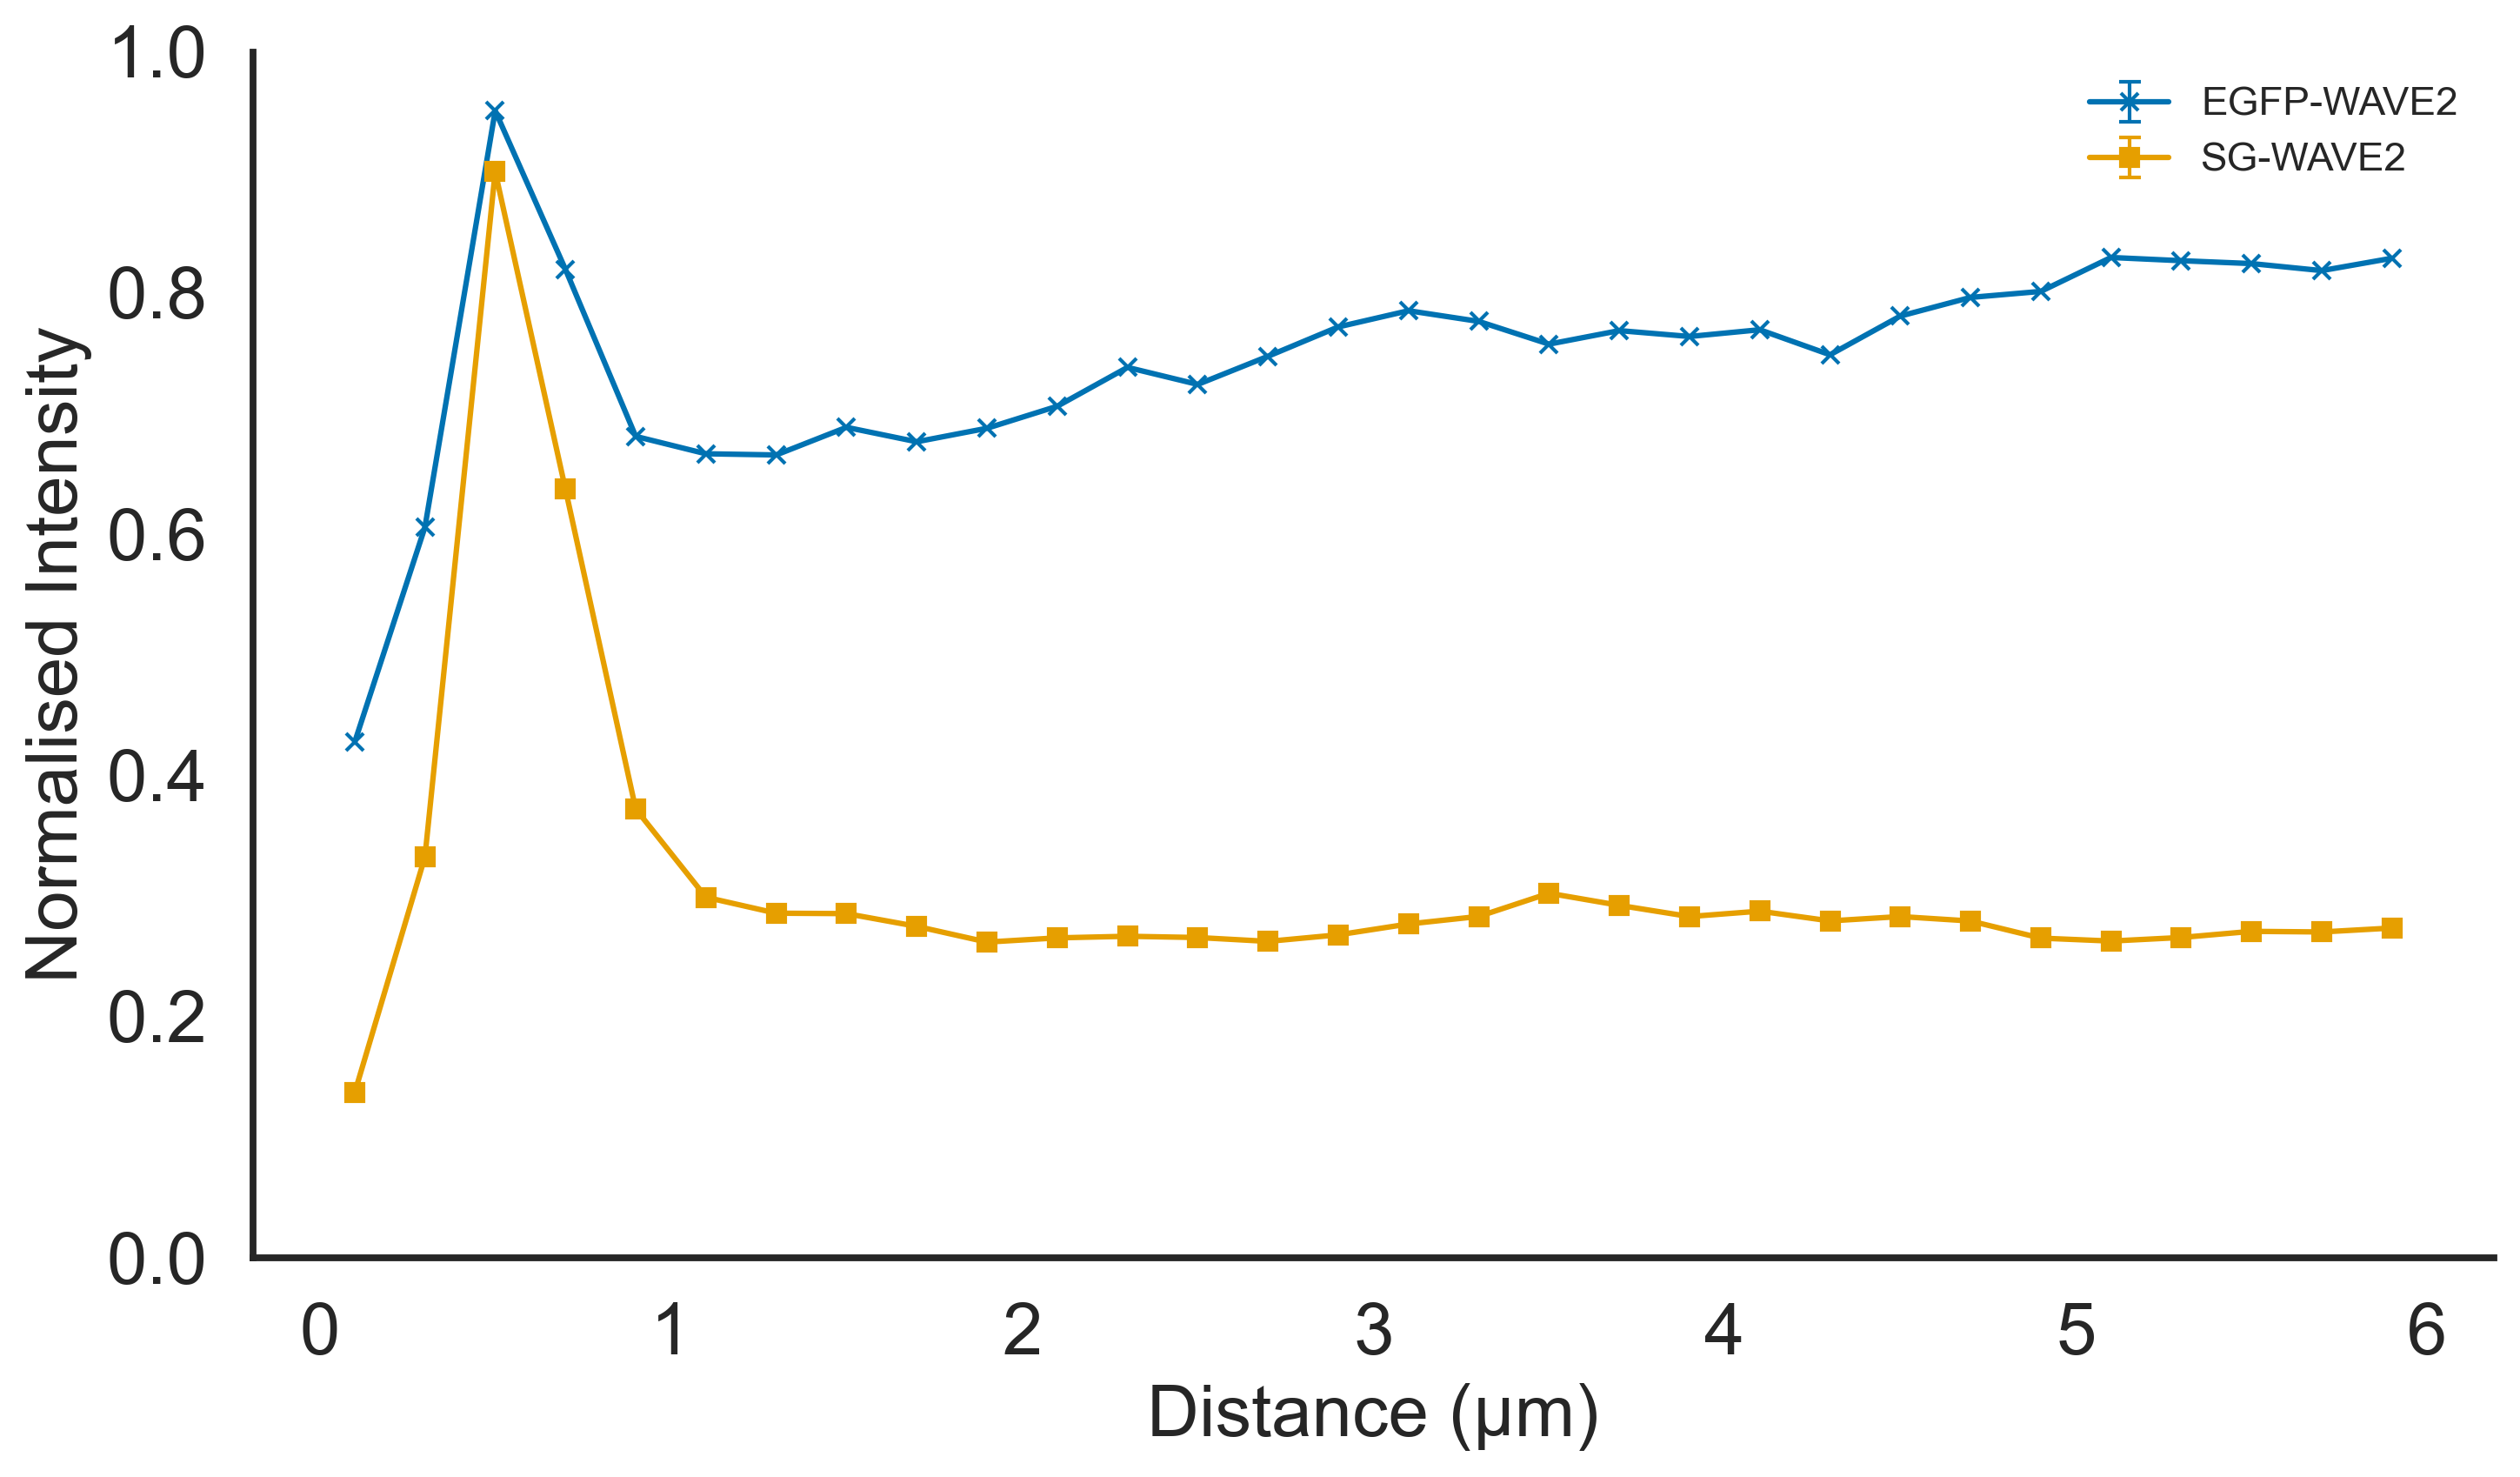

In [13]:
# Plotting intensity-distance curve for Elyra after photobleaching

# Markers and colours
markers = {'EGFP_W2': 'x', 'SG_W2': 's'}
colors = {
    'EGFP_W2': '#0072B2',   # 蓝 - 色盲友好
    'SG_W2': '#E69F00'      # 橙
}

# Plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# loop over
for gfp, marker in markers.items():
    subset = df_elyrra[df_elyrra["GFP"] == gfp]
    grouped = subset.groupby("DistanceMid")["LT456AvePer"]
    mean_vals = grouped.mean()
    sem_vals = grouped.apply(sem)

    ax.errorbar(
        mean_vals.index,
        mean_vals.values,
        yerr=sem_vals.values,
        label=gfp.replace("_W2", "-WAVE2"),
        marker=marker,
        linestyle='-',
        capsize=3,
        color=colors[gfp],
        markersize=5,
        linewidth=1.5,
        elinewidth=1
    )

# Axis Label
ax.set_xlabel("Distance (μm)", fontsize=20)
ax.set_ylabel("Normalised Intensity", fontsize=20)
ax.set_ylim(0, 1)

# Finalisation
ax.legend(
    frameon=False,
    fontsize=11,
    loc='upper right'
)

# Remove frame and grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)

ax.tick_params(axis='both', labelsize=20)
plt.savefig("SVG/LT_3Tags_W2_Elyra_30.png", dpi=600, bbox_inches='tight', transparent=True)

plt.tight_layout()
plt.show()